## Imports

In [1]:
# Imports

#General
import numpy as np
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Random Seed
from numpy.random import seed
seed(1)

# Audio
import librosa.display, librosa

## Get filenames

In [2]:
# Get files in data path
path='BirdSound/'
# Get Audio Files
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.wav'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 450 audio files in BirdSound/


## Prepare labels from filenames

In [3]:
labels =[]
classes=['Avocet','Bee_eater','Bittern','Bulbul','Bushshrike','Bush_warbler','Cisticola','Coot','Cormorant',
         'Crake','Crane', 'Cuckooshrike', 'Dove','Drongo','Eagle','Egret','Falcon','Gallinule', 'Grassbird', 
         'Grebe','Grouse','Gull','Hawk','Heron','Hornbill' ,'Jay' ,'Kingfisher','Kite','Lapwing', 'Lark', 
         'Leaf_warbler','Martin','Nightjar','Oystercatcher', 'Parrot', 'Pheasant','Pigeon', 'Pipit',  
         'Pitta','Plover','Quail','Rail','Raven','Reed_warbler','Roller','Sandpiper','Sparrow','Starling' , 
         'Stilt', 'Sunbird', 'Swift','Treecreeper','Trogon','Turaco', 'Wagtail','Waxbill','Weaver',
         'White_eye','Woodpecker']



color_dict={
    
           'Avocet':'blue','Bee_eater':'red','Bittern':'green','Bulbul':'black','Bushshrike':'magenta',
         'Bush_warbler':'magenta','Cisticola':'magenta','Coot':'magenta','Cormorant':'magenta',
         'Crake':'magenta','Crane':'magenta', 'Cuckooshrike':'magenta', 'Dove':'magenta','Drongo':'magenta',
         'Eagle':'magenta','Egret':'magenta','Falcon':'magenta','Gallinule':'magenta', 'Grassbird':'magenta', 
         'Grebe':'magenta','Grouse':'magenta','Gull':'magenta','Hawk':'magenta','Heron':'magenta',
         'Hornbill':'magenta' ,'Jay':'magenta' ,'Kingfisher':'magenta','Kite':'magenta','Lapwing':'magenta', 
         'Lark':'magenta','Leaf_warbler':'magenta','Martin':'magenta',   'Nightjar':'magenta',
         'Oystercatcher':'magenta', 'Parrot':'magenta', 'Pheasant':'magenta','Pigeon':'magenta', 
         'Pipit':'magenta','Pitta':'magenta','Plover':'magenta','Quail':'magenta','Rail':'magenta',
         'Raven':'magenta','Reed_warbler':'magenta','Roller':'magenta','Sandpiper':'magenta',
         'Sparrow':'magenta','Starling':'magenta' ,'Stilt':'magenta', 'Sunbird':'magenta', 'Swift':'magenta','Treecreeper':'magenta',
         'Trogon':'magenta','Turaco':'magenta', 'Wagtail':'magenta','Waxbill':'magenta','Weaver':'magenta',
         'White_eye':'magenta','Woodpecker':'magenta'
           
           }

color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

## Encode Labels

In [4]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

20 classes: Avocet, Coot, Crake, Crane, Dove, Gallinule, Grebe, Grouse, Lapwing, Nightjar, Oystercatcher, Pheasant, Pigeon, Plover, Quail, Rail, Sandpiper, Stilt, Swift, Turaco


## Parameters for MFCC

In [5]:
# Parameters
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing
n_neighbors=1       # Number of neighbors for kNN Classifier

## Function to Calculate Audio Features: MFCC

In [6]:
# Define Function to Calculate MFCC, Delta_MFCC and Delta2_MFCC
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    #feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector

## Load audio files, calculate features and create feature vectors

In [8]:
# Load audio files, calculate features and create feature vectors
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print ("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d feature vectors"%len(feature_vectors))

get 1 of 450 = BirdSound/Gallinule/XC131319 - Common Gallinule - Gallinula galeata.wav
get 2 of 450 = BirdSound/Gallinule/XC465599 - Common Gallinule - Gallinula galeata cachinnans.wav
get 3 of 450 = BirdSound/Gallinule/XC452961 - Common Gallinule - Gallinula galeata.wav
get 4 of 450 = BirdSound/Gallinule/XC45353 - Spot-flanked Gallinule - Porphyriops melanops crassirostris.wav
get 5 of 450 = BirdSound/Gallinule/XC91834 - Spot-flanked Gallinule - Porphyriops melanops.wav
get 6 of 450 = BirdSound/Gallinule/XC414334 - Common Gallinule - Gallinula galeata.wav
get 7 of 450 = BirdSound/Gallinule/XC368531 - Common Gallinule - Gallinula galeata.wav
get 8 of 450 = BirdSound/Gallinule/XC37123 - Purple Gallinule - Porphyrio martinica.wav
get 9 of 450 = BirdSound/Gallinule/XC7979 - Common Gallinule - Gallinula galeata.wav
get 10 of 450 = BirdSound/Gallinule/XC246282 - Common Gallinule - Gallinula galeata.wav
get 11 of 450 = BirdSound/Gallinule/XC384693 - Common Gallinule - Gallinula galeata.wav
g

get 95 of 450 = BirdSound/Crane/XC216976 - Common Crane - Grus grus.wav
get 96 of 450 = BirdSound/Crake/XC364028 - Rufous-faced Crake - Laterallus xenopterus.wav
get 97 of 450 = BirdSound/Crake/XC15483 - Rufous-faced Crake - Laterallus xenopterus.wav
get 98 of 450 = BirdSound/Crake/XC270595 - Chestnut-headed Crake - Anurolimnas castaneiceps.wav
get 99 of 450 = BirdSound/Crake/XC237988 - Chestnut-headed Crake - Anurolimnas castaneiceps castaneiceps.wav
get 100 of 450 = BirdSound/Crake/XC13469 - Black-banded Crake - Laterallus fasciatus~1.wav
get 101 of 450 = BirdSound/Crake/XC224864 - Rusty-flanked Crake - Laterallus levraudi.wav
get 102 of 450 = BirdSound/Crake/XC69265 - Spotless Crake - Porzana tabuensis.wav
get 103 of 450 = BirdSound/Crake/XC288426 - Grey-breasted Crake - Laterallus exilis.wav
get 104 of 450 = BirdSound/Crake/XC218852 - Russet-crowned Crake - Laterallus viridis.wav
get 105 of 450 = BirdSound/Crake/XC13469 - Black-banded Crake - Laterallus fasciatus.wav
get 106 of 450

get 187 of 450 = BirdSound/Dove/XC17077 - Ruddy Ground Dove - Columbina talpacoti.wav
get 188 of 450 = BirdSound/Dove/XC74980 - Common Ground Dove - Columbina passerina.wav
get 189 of 450 = BirdSound/Dove/XC300695 - Ring-necked Dove - Streptopelia capicola somalica.wav
get 190 of 450 = BirdSound/Dove/XC209306 - Blue Ground Dove - Claravis pretiosa.wav
get 191 of 450 = BirdSound/Coot/XC14381 - American Coot - Fulica americana~1.wav
get 192 of 450 = BirdSound/Coot/XC287245 - Andean Coot - Fulica ardesiaca.wav
get 193 of 450 = BirdSound/Coot/XC139909 - American Coot - Fulica americana.wav
get 194 of 450 = BirdSound/Coot/XC48557 - Red-fronted Coot - Fulica rufifrons.wav
get 195 of 450 = BirdSound/Coot/XC175423 - Eurasian Coot - Fulica atra.wav
get 196 of 450 = BirdSound/Coot/XC57425 - American Coot - Fulica americana.wav
get 197 of 450 = BirdSound/Coot/XC160661 - American Coot - Fulica americana.wav
get 198 of 450 = BirdSound/Coot/XC37846 - American Coot - Fulica americana.wav
get 199 of 4

get 283 of 450 = BirdSound/Plover/XC450072 - Magellanic Plover - Pluvianellus socialis.wav
get 284 of 450 = BirdSound/Plover/XC140325 - Little Ringed Plover - Charadrius dubius papuanus.wav
get 285 of 450 = BirdSound/Plover/XC59911 - Rufous-chested Plover - Charadrius modestus.wav
get 286 of 450 = BirdSound/Plover/XC371003 - Kentish Plover - Charadrius alexandrinus.wav
get 287 of 450 = BirdSound/Plover/XC309206 - Little Ringed Plover - Charadrius dubius curonicus.wav
get 288 of 450 = BirdSound/Plover/XC356536 - Common Ringed Plover - Charadrius hiaticula.wav
get 289 of 450 = BirdSound/Plover/XC345511 - European Golden Plover - Pluvialis apricaria.wav
get 290 of 450 = BirdSound/Plover/XC51732 - Collared Plover - Charadrius collaris.wav
get 291 of 450 = BirdSound/Plover/XC339475 - Common Ringed Plover - Charadrius hiaticula.wav
get 292 of 450 = BirdSound/Plover/XC378002 - Common Ringed Plover - Charadrius hiaticula.wav
get 293 of 450 = BirdSound/Plover/XC441251 - Grey Plover - Pluvialis 

get 370 of 450 = BirdSound/Oystercatcher/XC144971 - Eurasian Oystercatcher - Haematopus ostralegus.wav
get 371 of 450 = BirdSound/Pigeon/XC715 - Ruddy Pigeon - Patagioenas subvinacea.wav
get 372 of 450 = BirdSound/Pigeon/XC368234 - Dusky Pigeon - Patagioenas goodsoni.wav
get 373 of 450 = BirdSound/Pigeon/XC221376 - Short-billed Pigeon - Patagioenas nigrirostris.wav
get 374 of 450 = BirdSound/Pigeon/XC205976 - Picazuro Pigeon - Patagioenas picazuro.wav
get 375 of 450 = BirdSound/Pigeon/XC94615 - Common Wood Pigeon - Columba palumbus.wav
get 376 of 450 = BirdSound/Pigeon/XC246531 - White-bellied Green Pigeon - Treron sieboldii.wav
get 377 of 450 = BirdSound/Pigeon/XC39584 - Ruddy Pigeon - Patagioenas subvinacea.wav
get 378 of 450 = BirdSound/Pigeon/XC166060 - Orange-breasted Green Pigeon - Treron bicinctus.wav
get 379 of 450 = BirdSound/Pigeon/XC271973 - Plumbeous Pigeon - Patagioenas plumbea wallacei.wav
get 380 of 450 = BirdSound/Pigeon/XC257603 - Plumbeous Pigeon - Patagioenas plumbea

## Standardization: Zero-Mean and Unit-Variance

In [9]:
# Scale features using Standard Scaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)

Feature vectors shape: (450, 13)


## t-SNE

In [10]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import numpy as np
from glob import glob
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [11]:
labels = np.array(classes_num)
#labels_ids = np.array(classes_num)
labels = np.array(labels)
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}
label_ids = np.array([label_to_id_dict[x] for x in labels])

In [12]:
def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()


In [13]:
def visualize_scatter(data_2d, label_ids, figsize=(20,20)):
    plt.figure(figsize=figsize)
    plt.grid()
    
    nb_classes = len(np.unique(label_ids))
    
    for label_id in np.unique(label_ids):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color= plt.cm.Set1(label_id / float(nb_classes)),
                    linewidth='1',
                    alpha=0.8,
                    label=id_to_label_dict[label_id])
    plt.legend(loc='best')

In [14]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(scaled_feature_vectors)
X_embedded.shape

(450, 2)

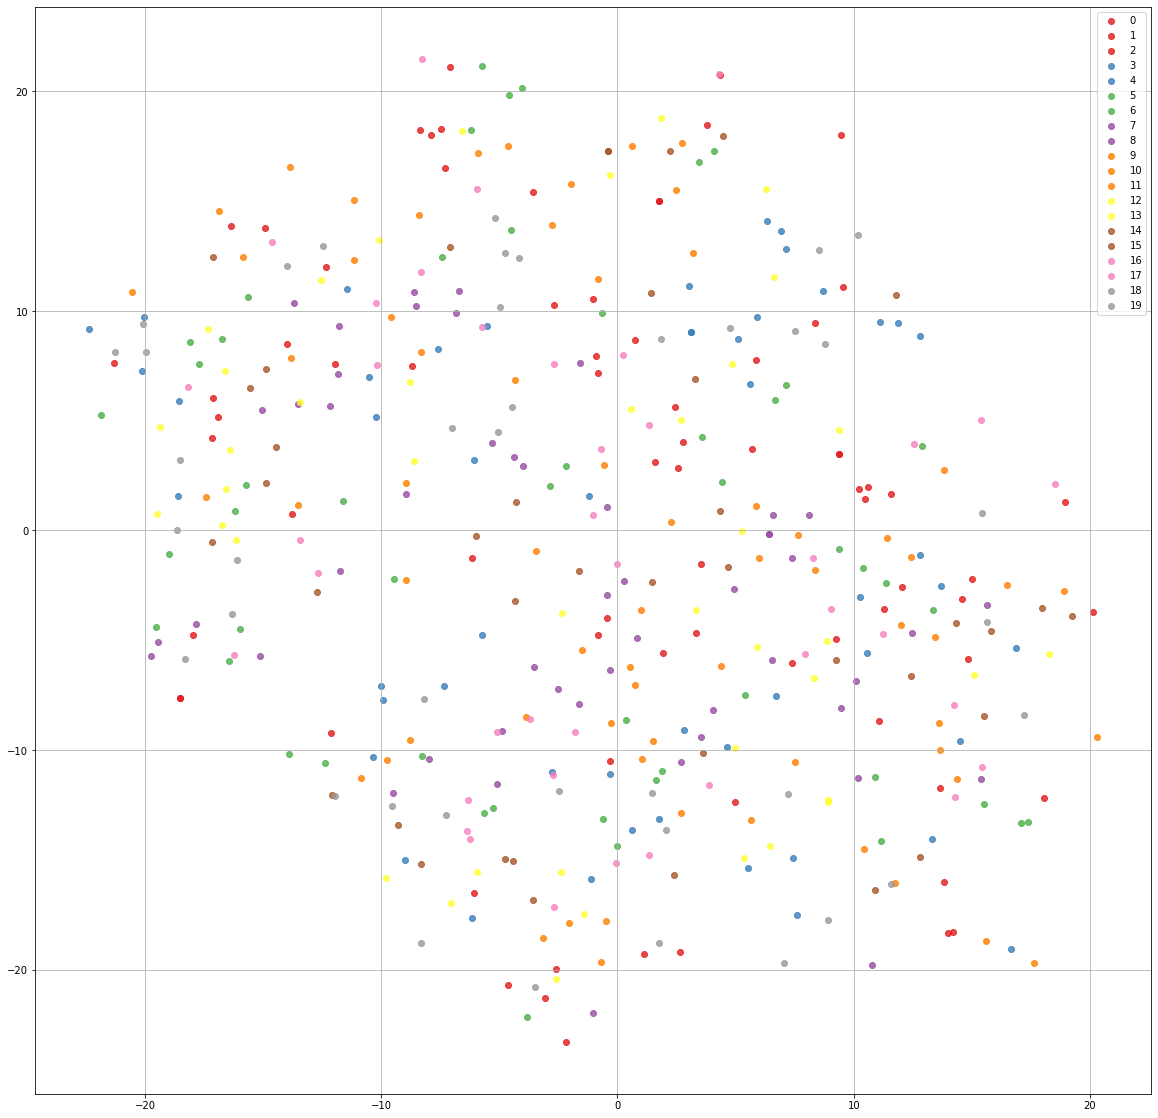

In [15]:
visualize_scatter(X_embedded,label_ids)

## Train and Test Sets

In [16]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [17]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (337, 13)
test_set shape: (113, 13)
train_classes shape: (337,)
test_classes shape: (113,)


## 1.kNN Classification

In [66]:
# KNN Classifier
n_neighbors=1
model_knn = KNeighborsClassifier(n_neighbors=n_neighbors)

In [67]:
# kNN
model_knn.fit(train_set, train_classes);

In [68]:
# Predict using the Test Set
predicted_labels = model_knn.predict(test_set)

## Evaluation

In [69]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.33 0.17 0.43 0.33 0.   0.17 0.   0.   0.17 0.   0.2  0.   0.2  0.
 0.   0.2  0.   0.   0.4  0.2 ]
Precision:  [0.33 0.08 0.6  0.33 0.   0.08 0.   0.   0.11 0.   0.14 0.   0.17 0.
 0.   0.2  0.   0.   0.4  0.5 ]
F1-Score:  [0.33 0.11 0.5  0.33 0.   0.11 0.   0.   0.13 0.   0.17 0.   0.18 0.
 0.   0.2  0.   0.   0.4  0.29]
Accuracy: 0.14  , 16
Number of samples: 113


In [70]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [23]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

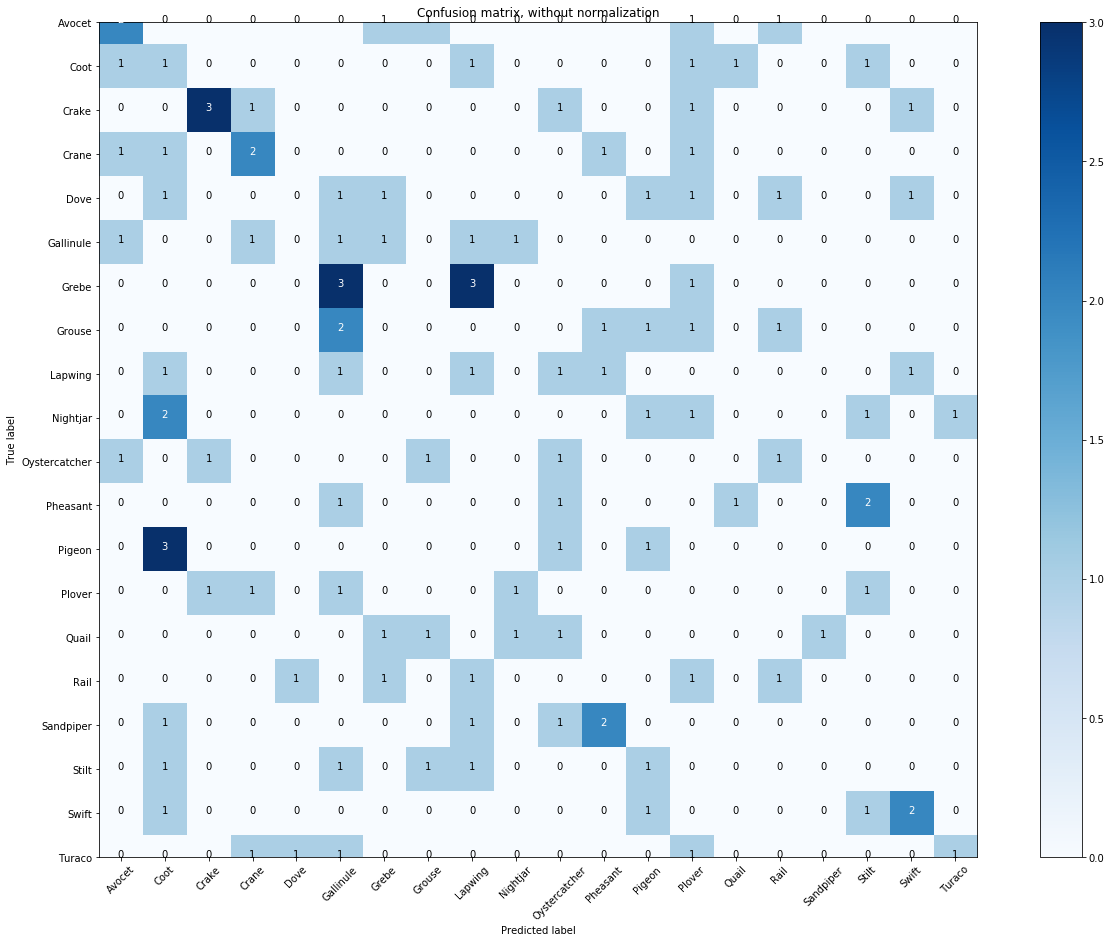

In [24]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [25]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [26]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

[ 6  7  4 16  0  1  9  3  8  4 15  9  2  9 14  8  3  6  6  6 14 17 11 14
 19 19  3 11  6  4 13 10 11 12 18  0 17 17  8  1  6  7 11  5 12  7 16  5
 16  5 16 10  6  2 11  7 10  7  4  4 13 13  0  5 15  1  9  2  7 19  8  2
  9  0 12 13 14 18 13  8  1 19 17  4 12 15 17 14  5  3 18 15  4 10 16  1
  9]
[ 8 11  5 10 15 17 13  0 18 12  6 17 10 19 10  1  1 13  8  8  9  1 10  7
  5  4 11  5  5  6  9  2 17 10 12  7  8  7  5  0  5 12 17  9  1 15 11  8
  8  6  1  0  5 18 14 13  7  5 13  1  3  5  6  3 13 14 12 13  5 13 11  3
  1 13  1  2  6 17 17 10 13  3 12 15  1  8  5 16  0 13  1  4 18 15 11  8
  1]
['Lapwing' 'Pheasant' 'Gallinule' 'Oystercatcher' 'Rail' 'Stilt' 'Plover'
 'Avocet' 'Swift' 'Pigeon' 'Grebe' 'Stilt' 'Oystercatcher' 'Turaco'
 'Oystercatcher' 'Coot' 'Coot' 'Plover' 'Lapwing' 'Lapwing' 'Nightjar'
 'Coot' 'Oystercatcher' 'Grouse' 'Gallinule' 'Dove' 'Pheasant' 'Gallinule'
 'Gallinule' 'Grebe' 'Nightjar' 'Crake' 'Stilt' 'Oystercatcher' 'Pigeon'
 'Grouse' 'Lapwing' 'Grouse' 'Gallinule' 'Avo

## 2. Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
model_Logistic = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

In [29]:
model_Logistic.fit(train_set, train_classes);

## Save / Load Trained Model

In [31]:
# Save
#joblib.dump(model_Logistic, 'Mfcc_trainedLogisticRegression.joblib')
#Load
#svclassifier = joblib.load('filename.joblib') 

In [32]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = model_Logistic.predict(test_set)

## Evaluation

In [33]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.67 0.33 0.14 0.67 0.14 0.   0.14 0.5  0.17 0.17 0.2  0.2  0.   0.
 0.   0.   0.   0.   0.4  0.4 ]
Precision:  [0.57 0.15 0.25 0.57 0.1  0.   0.33 0.5  0.11 0.11 0.5  0.25 0.   0.
 0.   0.   0.   0.   0.18 0.5 ]
F1-Score:  [0.62 0.21 0.18 0.62 0.12 0.   0.2  0.5  0.13 0.13 0.29 0.22 0.   0.
 0.   0.   0.   0.   0.25 0.44]
Accuracy: 0.21  , 24
Number of samples: 113


In [34]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [35]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

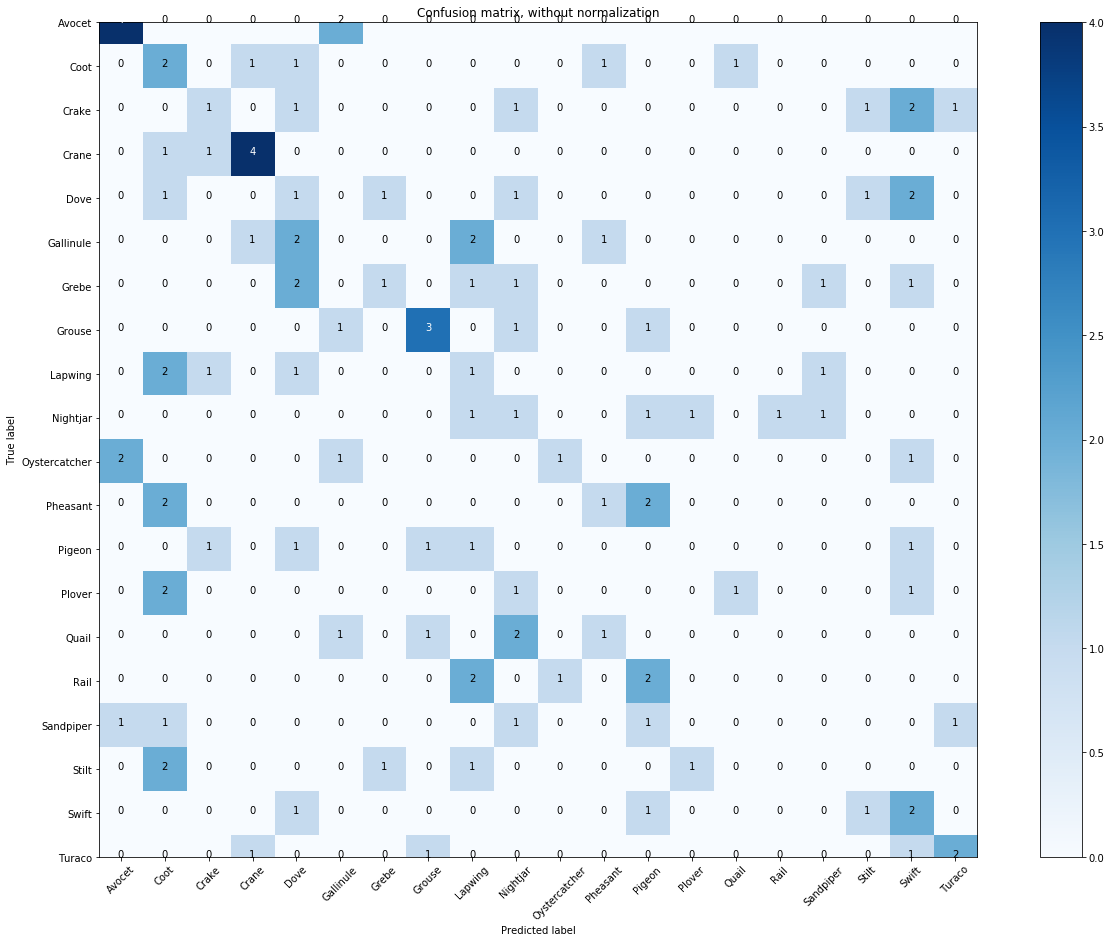

In [36]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [37]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [38]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

[ 6  4 16  0  9  8  8  4 15  2  9  2  9 14  8  3  6  6 14 17 11 14 19 11
  6  4 13 11 12 18  0 17 17  5  1  6  2 11  5 12 16  5 16  5 16 10  6  1
  7 10  7  4  4 19 13 13  5 15  2  7 15 19  8 12  2 10  9 12 13 14 18 13
  8  1 17 12 15 17 14  5  3 18 15  4 10 16  2  1  9]
[ 4  9  0  5 13  4 16 18 12 19  8 18 15  5  1  1  9 18  9  1 12 11  3 12
 16  1  9  1  2 12  5  6 13  4 14  4 17  1  4  4 12  8  9  3  1  0  8  3
 12  5  5 17  6  7 14  1 11  8  9  9 10 18  1  7  4  0 12  8 18  7 17  1
  2  4  1 18  8  8  9  8  2  4 12 18 18 19 18 11 16]
['Dove' 'Nightjar' 'Avocet' 'Gallinule' 'Plover' 'Dove' 'Sandpiper'
 'Swift' 'Pigeon' 'Turaco' 'Lapwing' 'Swift' 'Rail' 'Gallinule' 'Coot'
 'Coot' 'Nightjar' 'Swift' 'Nightjar' 'Coot' 'Pigeon' 'Pheasant' 'Crane'
 'Pigeon' 'Sandpiper' 'Coot' 'Nightjar' 'Coot' 'Crake' 'Pigeon'
 'Gallinule' 'Grebe' 'Plover' 'Dove' 'Quail' 'Dove' 'Stilt' 'Coot' 'Dove'
 'Dove' 'Pigeon' 'Lapwing' 'Nightjar' 'Crane' 'Coot' 'Avocet' 'Lapwing'
 'Crane' 'Pigeon' 'Gallinule' 'Gal

## 3.SVM

In [41]:
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib
model_svm = SVC(kernel='rbf', C = 10.0, gamma=0.1) 

/home/rutherford/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [42]:
# SVM
#model_svm.fit(train_set, train_classes);
model_svm.fit(train_set, train_classes);

## Save / Load Trained Model

In [45]:
# Save
#joblib.dump(model_svm, 'trainedSVM.joblib')
#Load
#svclassifier = joblib.load('filename.joblib') 

In [46]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = model_svm.predict(test_set)

## Evaluation

In [47]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.67 0.17 0.71 0.5  0.   0.   0.   0.5  0.   0.17 0.   0.   0.   0.
 0.2  0.2  0.   0.   0.4  0.  ]
Precision:  [0.5  0.09 0.5  0.43 0.   0.   0.   0.6  0.   0.17 0.   0.   0.   0.
 0.5  0.25 0.   0.   0.33 0.  ]
F1-Score:  [0.57 0.12 0.59 0.46 0.   0.   0.   0.55 0.   0.17 0.   0.   0.   0.
 0.29 0.22 0.   0.   0.36 0.  ]
Accuracy: 0.19  , 21
Number of samples: 113


/home/rutherford/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rutherford/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [48]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [ ]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [ ]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

## 4.Naive Bayes

In [71]:
from sklearn.naive_bayes import GaussianNB

model_NB = GaussianNB()

In [72]:
model_NB.fit(train_set, train_classes);

## Save / Load Trained Model

In [73]:
# Save
joblib.dump(model_NB, 'trainedNaiveBayes.joblib')
#Load
#svclassifier = joblib.load('filename.joblib') 

['trainedNaiveBayes.joblib']

In [74]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = model_NB.predict(test_set)

## Evaluation

In [75]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.67 0.17 0.29 0.17 0.   0.   0.14 0.17 0.17 0.   0.4  0.2  0.2  0.
 0.   0.   0.   0.2  0.4  0.4 ]
Precision:  [0.4  0.09 0.33 0.25 0.   0.   0.33 0.5  0.09 0.   0.4  0.11 0.33 0.
 0.   0.   0.   0.08 0.22 0.22]
F1-Score:  [0.5  0.12 0.31 0.2  0.   0.   0.2  0.25 0.12 0.   0.4  0.14 0.25 0.
 0.   0.   0.   0.12 0.29 0.29]
Accuracy: 0.18  , 20
Number of samples: 113


/home/rutherford/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rutherford/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [76]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [77]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

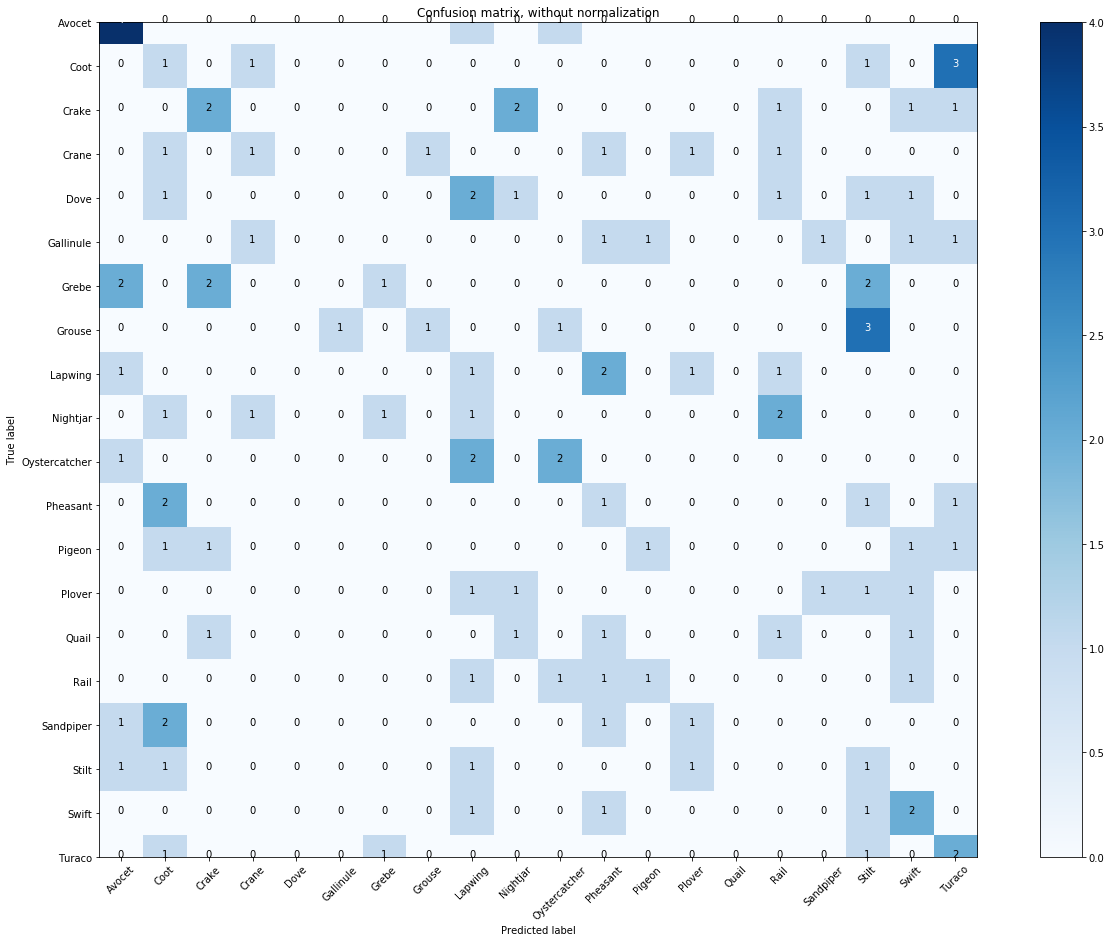

In [78]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [79]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [80]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

[ 6  7  4 16  0  1  9  3  8  8  4 15  9  2  9 14  8  3  6  6  6 14 17 11
 14 19 19  3 11  4 13 10 11 12 18 17  8  5  1  6 11  5 12  7 16  5 16  5
 16  6  2  1  7 10  7  4  4 13 13  5 15  9  2  7 15 19  8  2 10  9  0 12
 13 14 18 13  1 17  4 12 15 17 14  5  3  3 18 15  4 16  2  1  9]
[ 2 17 17  0  8 17  6  7 11 15  9  8 15 18  3  2 13  1  0 17  2  9 13 19
 11 17  1 11 17  1  9  0  1  2  8  8  0 19 19 17  1 16  1 17 11 12 13  3
  1  0  9  3 10  8  5 15  8 17 16 11 12  8  9 17 10  6 11 19  8  1 10 19
 18 18 17  8 19  1  8 18 18  0 15 18 15 13 11 11 18  1 15 19 15]
['Crake' 'Stilt' 'Stilt' 'Avocet' 'Lapwing' 'Stilt' 'Grebe' 'Grouse'
 'Pheasant' 'Rail' 'Nightjar' 'Lapwing' 'Rail' 'Swift' 'Crane' 'Crake'
 'Plover' 'Coot' 'Avocet' 'Stilt' 'Crake' 'Nightjar' 'Plover' 'Turaco'
 'Pheasant' 'Stilt' 'Coot' 'Pheasant' 'Stilt' 'Coot' 'Nightjar' 'Avocet'
 'Coot' 'Crake' 'Lapwing' 'Lapwing' 'Avocet' 'Turaco' 'Turaco' 'Stilt'
 'Coot' 'Sandpiper' 'Coot' 'Stilt' 'Pheasant' 'Pigeon' 'Plover' 'Crane'
 'Coo

## 5.Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
model_RFC = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)

In [83]:
model_RFC.fit(train_set, train_classes);

## Save / Load Trained Model

In [86]:
# Save
#joblib.dump(model, 'trainedRandomForest.joblib')
#Load
#svclassifier = joblib.load('filename.joblib') 

In [87]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = model_RFC.predict(test_set)

## Evaluation

In [88]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.5  0.33 0.29 0.67 0.   0.   0.   0.5  0.33 0.5  0.   0.   0.   0.
 0.   0.   0.   0.   0.2  0.  ]
Precision:  [0.43 0.17 0.5  0.36 0.   0.   0.   0.16 0.08 0.2  0.   0.   0.   0.
 0.   0.   0.   0.   0.25 0.  ]
F1-Score:  [0.46 0.22 0.36 0.47 0.   0.   0.   0.24 0.12 0.29 0.   0.   0.   0.
 0.   0.   0.   0.   0.22 0.  ]
Accuracy: 0.18  , 20
Number of samples: 113


/home/rutherford/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rutherford/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [89]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [ ]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [ ]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

## 6.Gausian Mixture Model

In [ ]:
from sklearn.mixture import GaussianMixture
model_GMM = GaussianMixture()

In [ ]:
model_GMM.fit(train_set, train_classes);

## Save / Load Trained Model

In [ ]:
# Save
joblib.dump(model_GMM, 'trainedGMM.joblib')
#Load
#svclassifier = joblib.load('filename.joblib') 

In [1]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = model_GMM.predict(test_set)

NameError: name 'model_GMM' is not defined

## Evaluation

In [ ]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [ ]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [ ]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])

## 7.Bayesian Mixture Models

In [ ]:
from sklearn.mixture import BayesianGaussianMixture
model_BGMM = BayesianGaussianMixture()

In [ ]:
model_BGMM.fit(train_set, train_classes);

## Save / Load Trained Model

In [ ]:
# Save
joblib.dump(model_BGMM, 'trainedBGMM.joblib')
#Load
#svclassifier = joblib.load('filename.joblib') 

In [ ]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = model_BGMM.predict(test_set)

## Evaluation

In [ ]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [ ]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [ ]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])